In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


# parameters for generating map

In [3]:
nside = 128
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 5)*1.e9

# define the model with these parameters (for comparison)

In [60]:
input_model = ff.model(freqs, A, alpha, beta, gamma)
input_model.shape

(5, 384)

# define 2d and 1d data

In [17]:
PS_data = ff.PS_data(freqs, A, alpha, beta, gamma)

In [20]:
PS_data_1d = PS_data[0]
#1d data at 30 GHz.

In [30]:
#try residual stuff with this new 'full_model' function
def residuals(params, ells, freqs, data):
    chi2 = 0
    amp, alpha, beta, gamma = params
    model = ff.full_model(ells, freqs, amp, alpha, beta, gamma)

    #set up array of 2/(2*ell+1) then multiply by C_ell^2
    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * model**2
    chi2 = (data[2:] - model[2:])**2 / cosmic_var[2:]
#     print(chi2)
    return np.sum(chi2)

# Fit 0: test if minimize is moving

In [31]:
start=time.time()
result = minimize(residuals, [1e3, -1, -1, -3], args=(ells, freqs, PS_data), bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

208.27679896354675


In [32]:
result

      fun: 2811.7576517924444
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04347385,  0.00645741, -0.00159162,  0.00463842])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 150
      nit: 15
   status: 0
  success: True
        x: array([999.9979063 ,  -4.24334977,  -3.85019602,  -2.76123515])

In [45]:
x = result.x

In [66]:
fitted_model = ff.model(freqs, x[0], x[1], x[2], x[3])
fitted_model.shape

(5, 384)

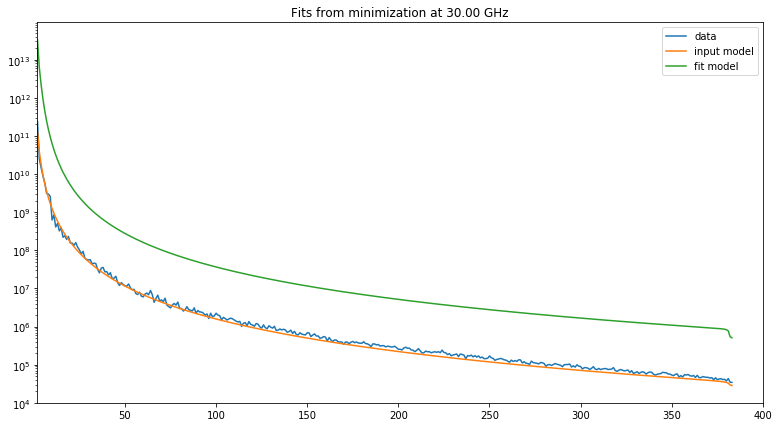

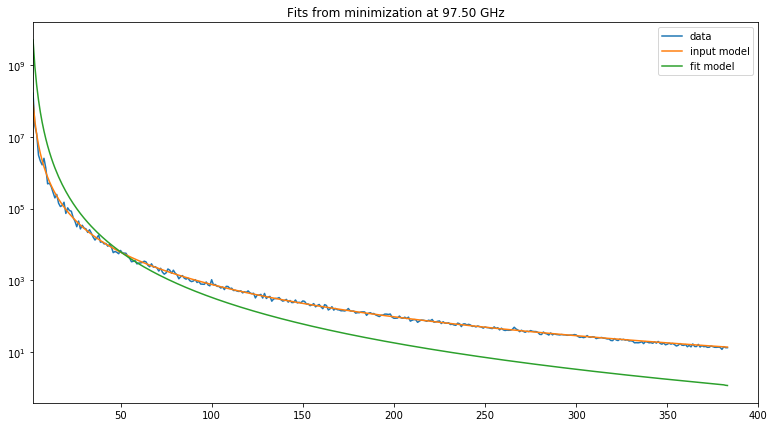

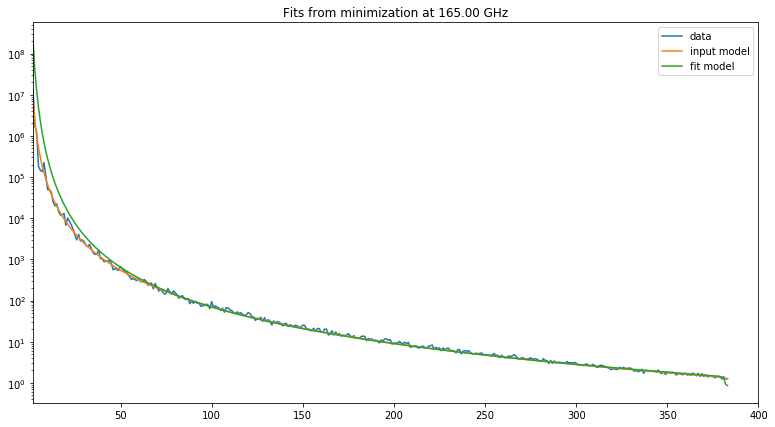

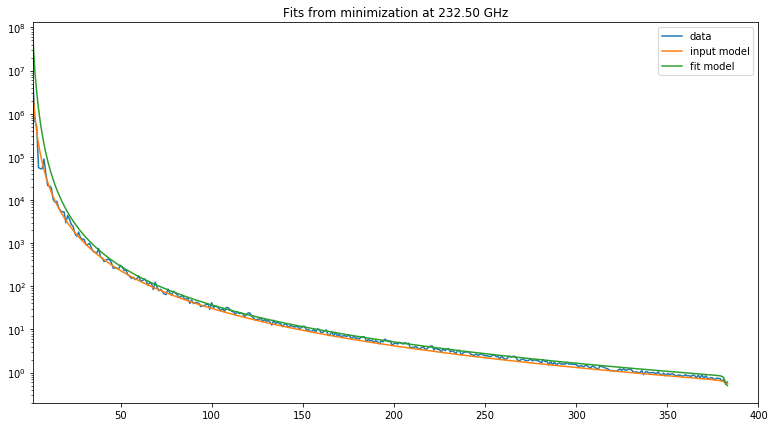

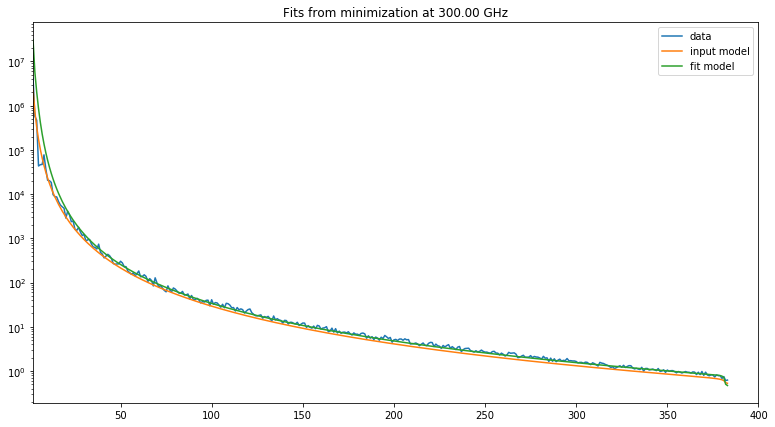

In [68]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data[i], label='data')
    semilogy(input_model[i], label='input model')
    semilogy(fitted_model[i], label='fit model')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)

In [69]:
#okay, so it's kind of worked, though not super well. But it's running and moving.
#Test if the system is consistent now, with same input vector should get same output

# Fit 1: see if system is deterministic

In [70]:
start=time.time()
result_1 = minimize(residuals, [1e3, -1, -1, -3], args=(ells, freqs, PS_data), bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

199.27151012420654


In [71]:
result_1

      fun: 2811.7576517924444
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04347385,  0.00645741, -0.00159162,  0.00463842])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 150
      nit: 15
   status: 0
  success: True
        x: array([999.9979063 ,  -4.24334977,  -3.85019602,  -2.76123515])

In [72]:
x1 = result_1.x

In [73]:
x-x1

array([0., 0., 0., 0.])

In [74]:
#good, so model is deterministic as it should be now. Now can test different initial points and/or constraints/methods

# Fit 2: start closer to correct amplitude

In [82]:
start=time.time()
result_2 = minimize(residuals, [1.5e3, -1, -1, -3], args=(ells, freqs, PS_data), bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

226.13190293312073


In [78]:
x2 = result_2.x
print(x2)

[1499.99665476   -3.00194856   -3.04267332   -2.52866634]


In [79]:
fit2= ff.model(freqs, x2[0], x2[1], x2[2], x2[3])

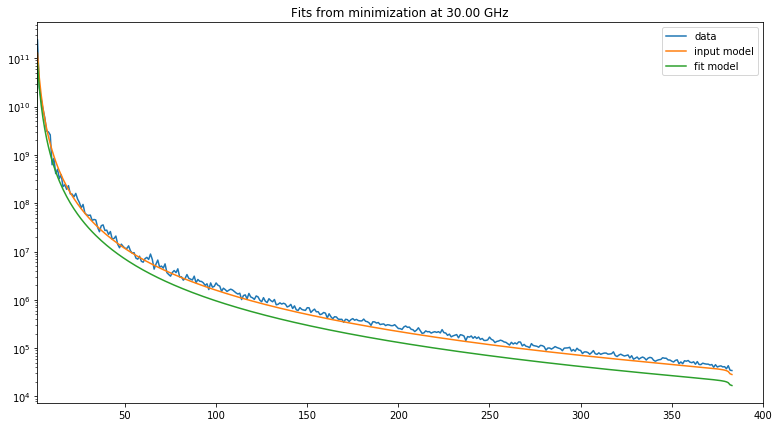

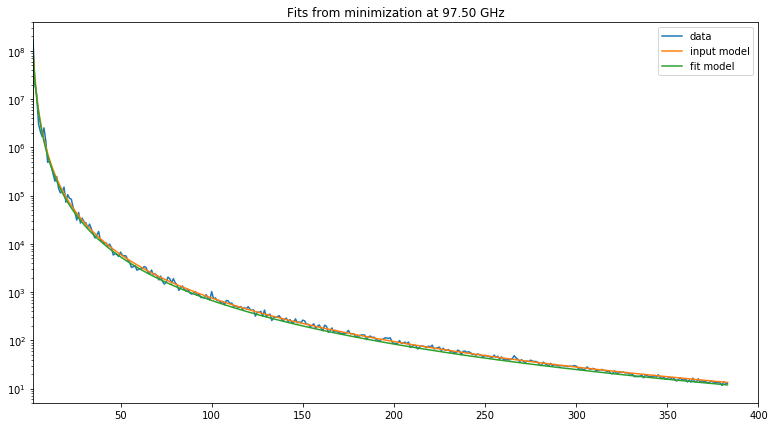

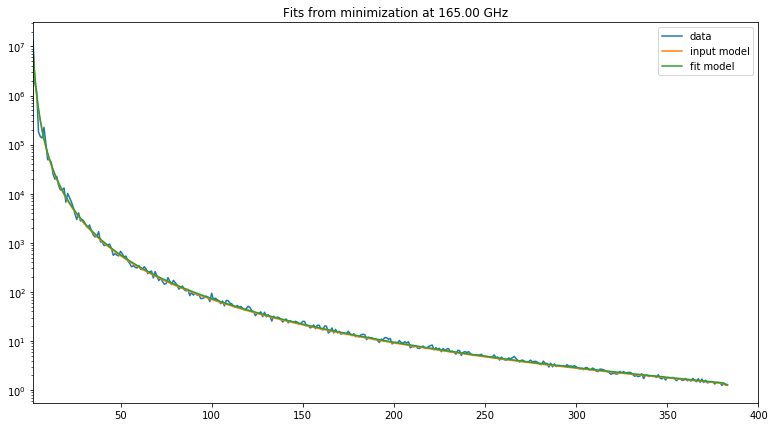

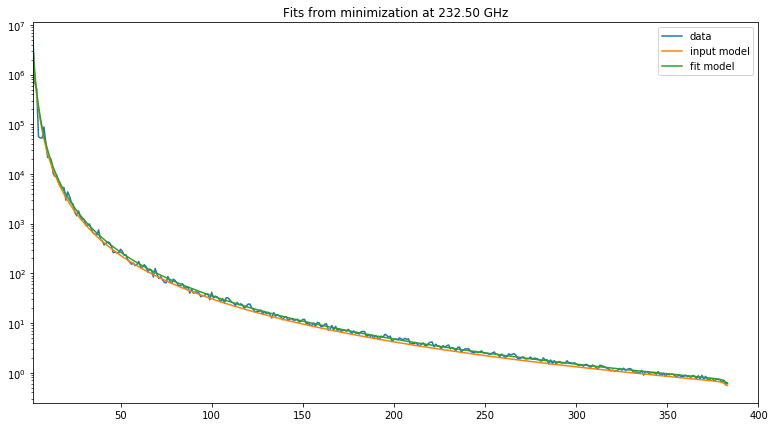

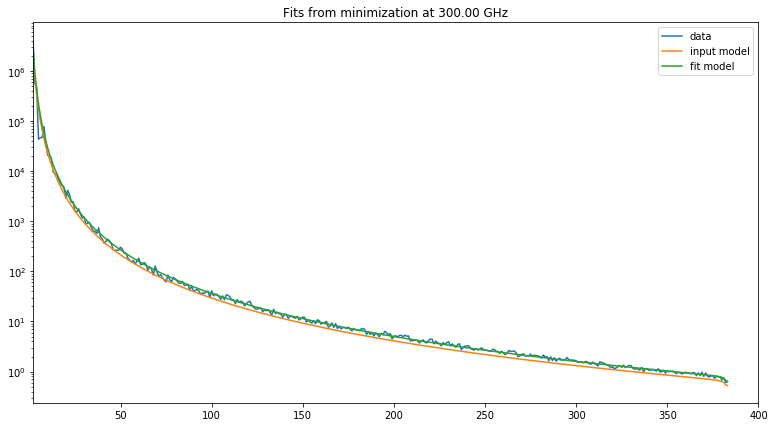

In [80]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data[i], label='data')
    semilogy(input_model[i], label='input model')
    semilogy(fit2[i], label='fit model')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)

# Fit 3: start at correct amplitude and see what others are found as

In [83]:
start=time.time()
result_3 = minimize(residuals, [A, -1, -1, -3], args=(ells, freqs, PS_data), bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

207.46563911437988


In [84]:
x3 = result_3.x
print(x3)

[1699.99818759   -3.06980754   -3.14449518   -2.48882821]


In [85]:
fit3= ff.model(freqs, x3[0], x3[1], x3[2], x3[3])

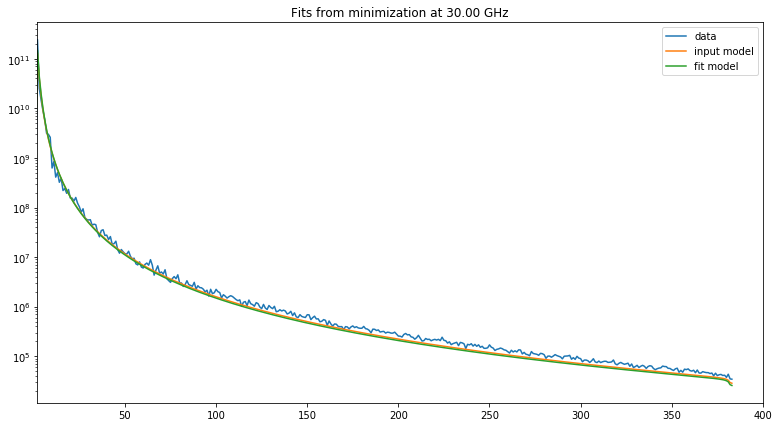

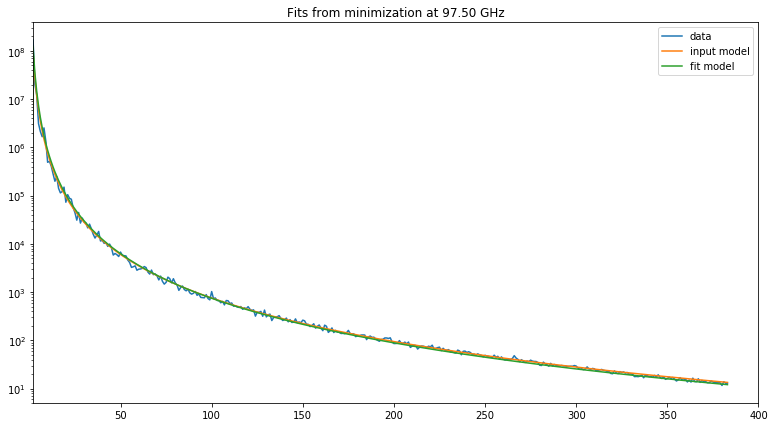

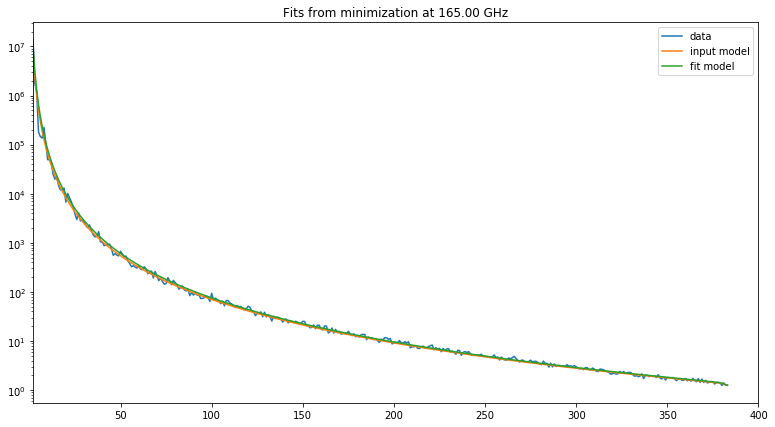

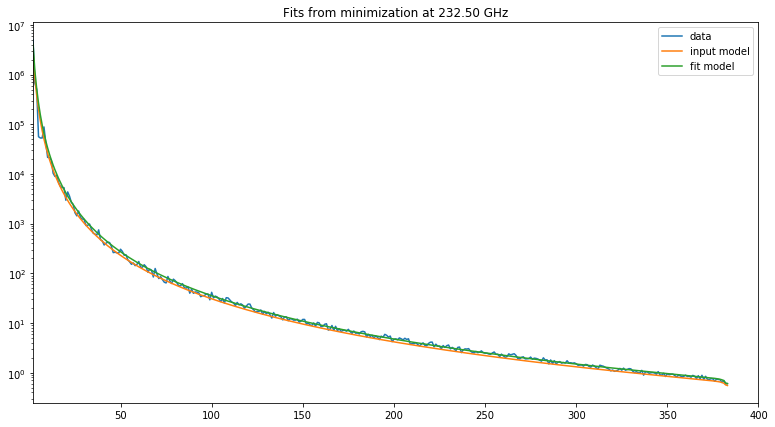

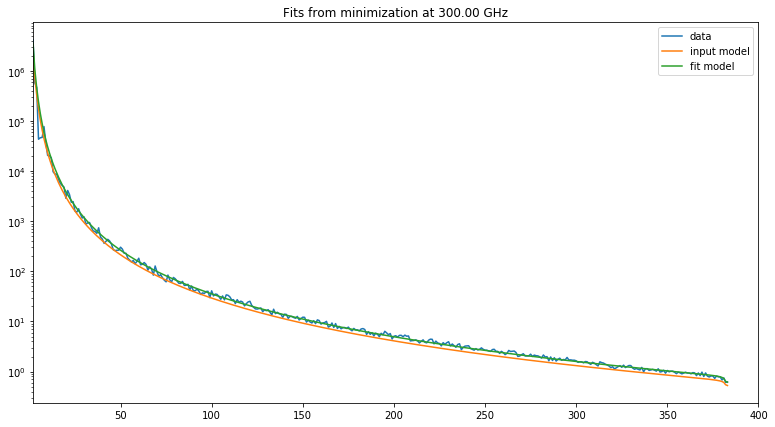

In [86]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data[i], label='data')
    semilogy(input_model[i], label='input model')
    semilogy(fit3[i], label='fit model')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)

In [ ]:
#interesting. So it seems like the minimize program doesn't want to move away from the input amplitude, but
#can find pretty good values for the other parameters 

# Fit 4: try this on a set of data generated from different inputs

In [87]:
A1 = 1.4e3
alpha1 = -3.5
beta1 = -2.8
gamma1 = -3.0

In [88]:
PS_data1 = ff.PS_data(freqs, A1, alpha1, beta1, gamma1)

In [89]:
input_model1 = ff.model(freqs, A1, alpha1, beta1, gamma1)

In [90]:
start=time.time()
result4 = minimize(residuals, [1e3, -1, -1, -3], args=(ells, freqs, PS_data1), bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

420.78942012786865


In [91]:
x4 = result4.x
print(x4)

[1000.03512075   -3.41913081   -2.443418     -5.80968345]


In [92]:
print(A1, alpha1, beta1, gamma1)

1400.0 -3.5 -2.8 -3.0


In [104]:
fit4= ff.model(freqs, x4[0], x4[1], x4[2], x4[3])

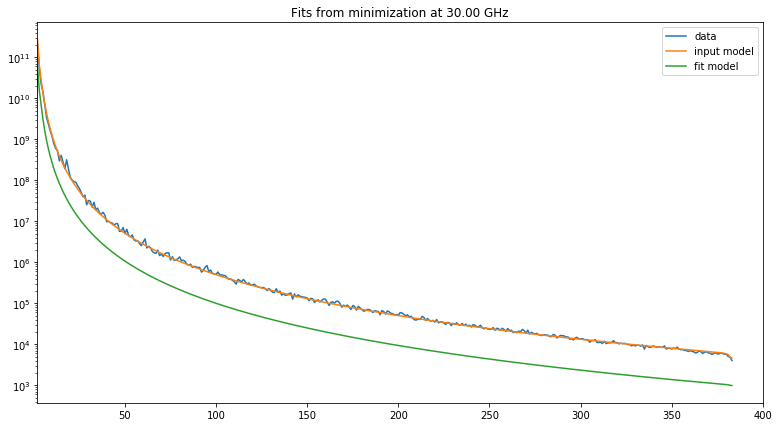

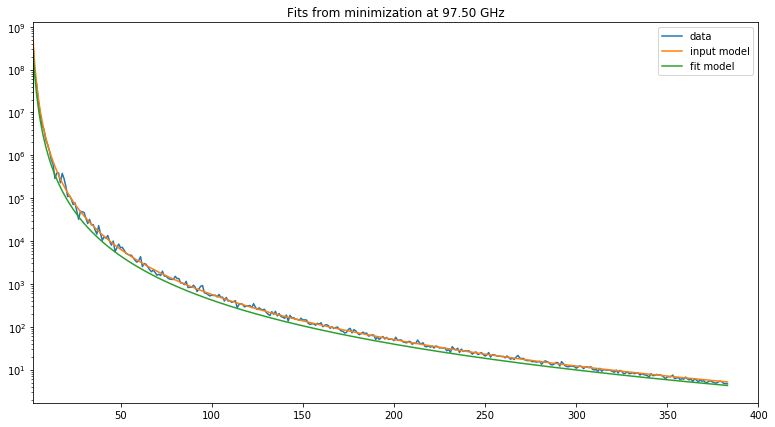

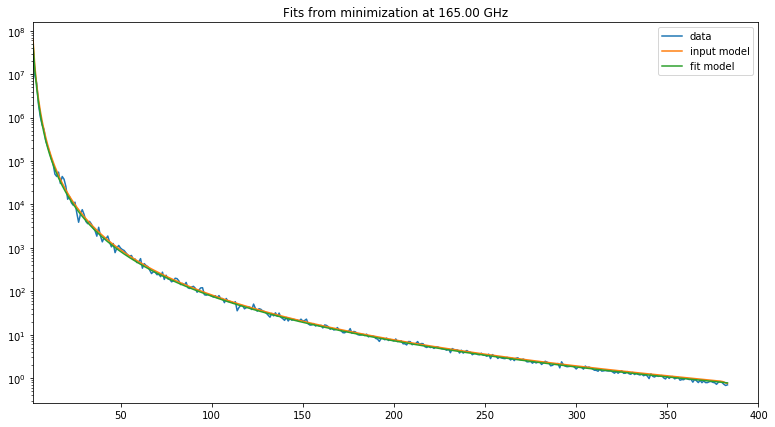

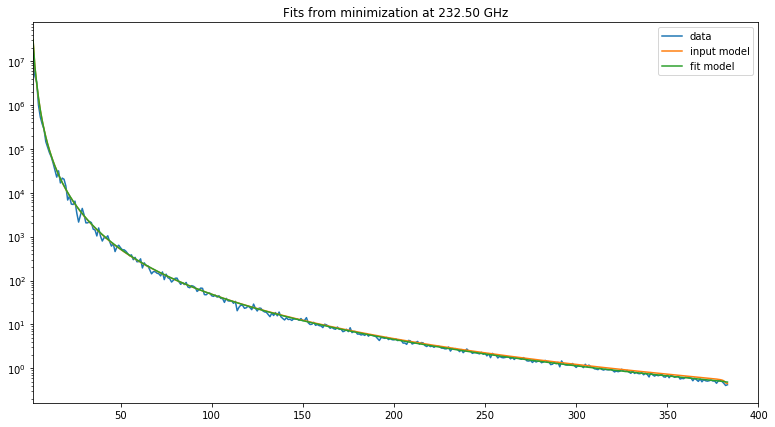

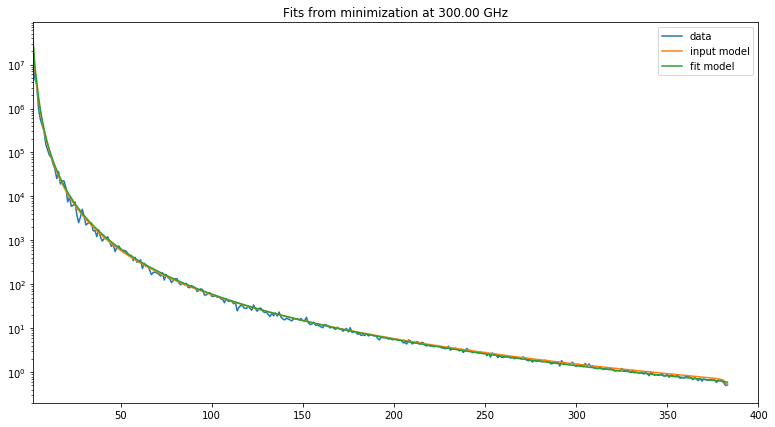

In [105]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data1[i], label='data')
    semilogy(input_model1[i], label='input model')
    semilogy(fit4[i], label='fit model')
#     semilogy(ff.model(freqs, x5[0], -3.5, x5[2], x5[3])[i], label='fit corrected')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)

In [93]:
#so again the amplitude doesn't want to move...

# Fit 5: correct amplitude on these secondary data

In [94]:
start=time.time()
result5 = minimize(residuals, [A1, -1, -1, -3], args=(ells, freqs, PS_data1), bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

225.976815700531


In [95]:
x5 = result5.x
print(x5)

[1399.99942946   -3.54262018   -2.79901373   -3.05761602]


In [96]:
print(A1, alpha1, beta1, gamma1)

1400.0 -3.5 -2.8 -3.0


In [97]:
fit5= ff.model(freqs, x5[0], x5[1], x5[2], x5[3])

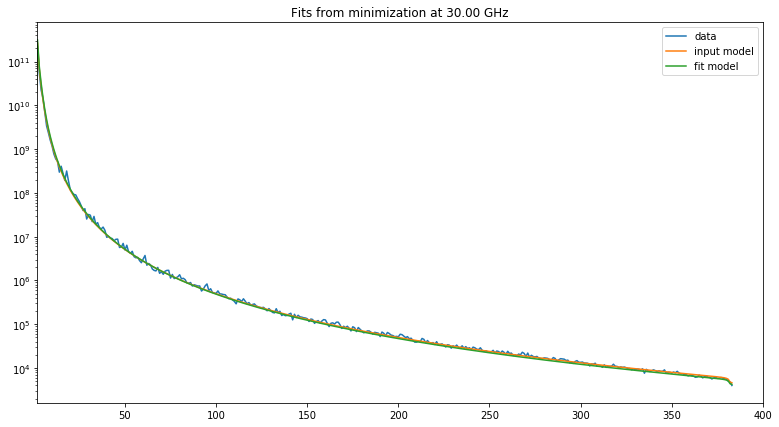

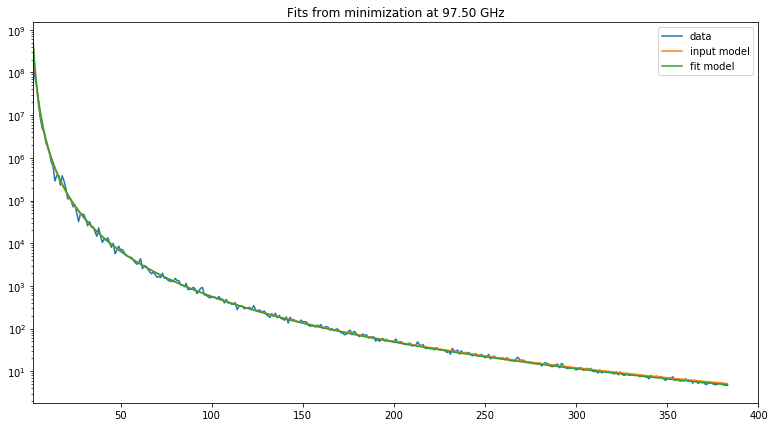

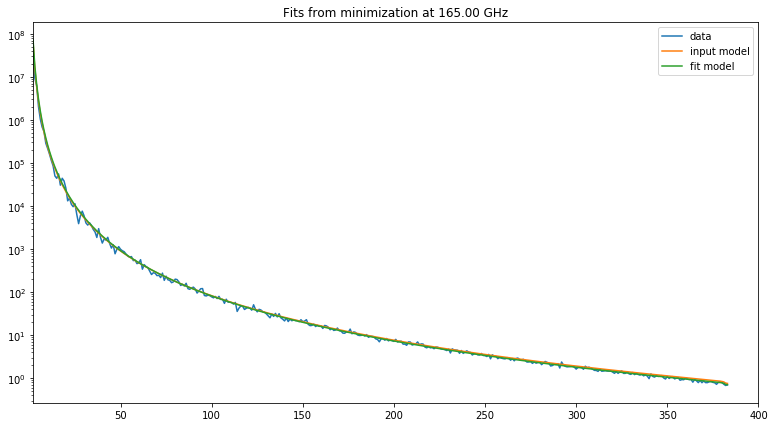

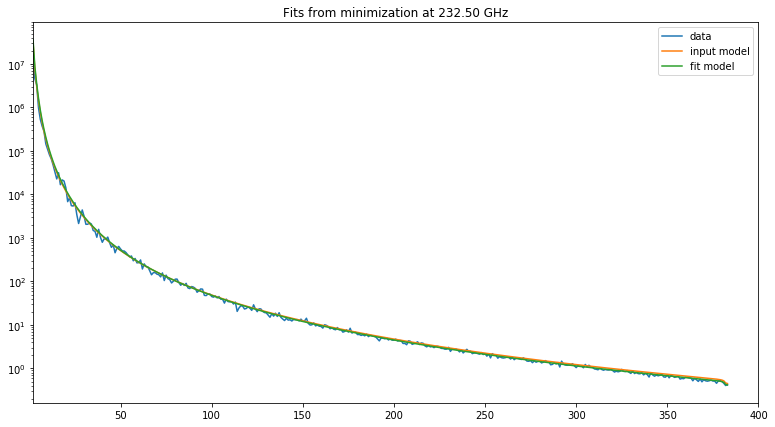

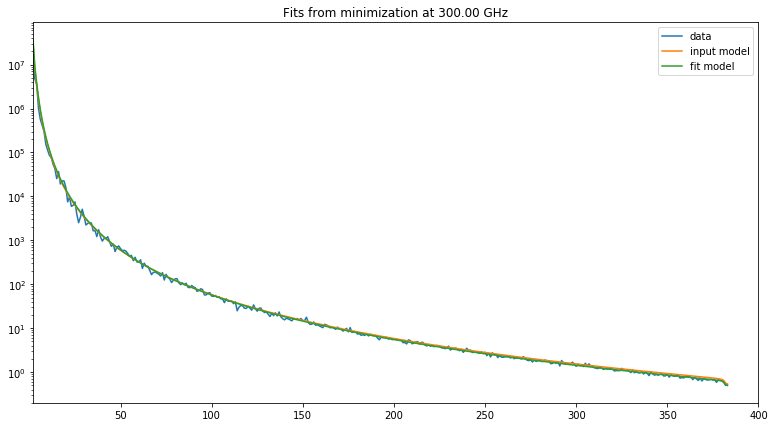

In [102]:
for i in range(len(freqs)):
    figure(figsize=(13,7))
    semilogy(PS_data1[i], label='data')
    semilogy(input_model1[i], label='input model')
    semilogy(fit5[i], label='fit model')
#     semilogy(ff.model(freqs, x5[0], -3.5, x5[2], x5[3])[i], label='fit corrected')
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    xlim(2,400)

In [103]:
#okay, so does well at different input parameters too, that's good